# Return on Housing in Budapest
We would like to provide the complete description of the analysis that we have performed in order to compute the realized ex-post return on housing in Budapest. We compute the nominal return on an average flat in Budapest. We make several important assumptions, and we would like to be explicit about them. We provide the code written in Python, so that the interested reader could change the assumptions and re-compute the return according to their preferences.

In [1]:
# Impport the necessary packages
import pandas as pd
import math
import numpy as np
import requests
import matplotlib.pyplot as plt
import os

pd.options.display.float_format = '{: ,.2f}'.format

### Data
Aggregated data on rental rates are difficult to come by. We rely on the average rental rates per square meter published by ingatlannet.hu, which also includes the data on rents in Budapest:

data missing from ingatlannet.hu - using backup

Data on rents per sq. m.: extracted from ingatlan.hu:


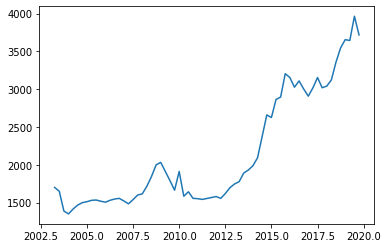

In [2]:
# Download the data on rents per sq.m. from ingatlannet.hu
dls = "https://pic01.ingatlannet.hu/xlsx/statisztika/statisztika_20megye.xlsx"
resp = requests.get(dls)
with open('ingatlannet.xls', 'wb') as output:
    output.write(resp.content)

# Use back-up file if the source no longer exists
if resp.status_code == 404:
    from shutil import copy
    copy("backup/ingtlannet_rents_prices_BP.xls","ingatlannet.xls")
    print("data missing from ingatlannet.hu - using backup")

    
data_rent = pd.read_excel('ingatlannet.xls', sheet_name = 5, header=0, 
                     names=['month', 'rent'], usecols = [0, 1], skiprows = 1)
data_price = pd.read_excel('ingatlannet.xls', sheet_name = 2, header=0, 
                     names=['month', 'price'], usecols = [0, 1], skiprows = 1)

# Construct the vectors of years and quarters for which we have data
y_min = int(data_rent['month'][0][0:4])
y_max = int(data_rent['month'][len(data_rent['month'])-1][0:4])

y = []
q = []
for yy in range(y_min, y_max+1):
    y.extend(list(np.tile(yy,4)))
    q.extend([1,2,3,4])

m_max = int(data_rent['month'][len(data_rent['month'])-1][5:7])
q_max = math.floor(m_max/3)
y = y[0:-(4-q_max)]
q = q[0:-(4-q_max)]
date = np.add(y, [x/4 for x in q])

# Construct the vector of nominal rents
# There are missing values for some of the months, 
# so we use the latest available observation in each quarter
m = [['03','02','01'], ['06','05','04'], ['09','08','07'], ['12','11','10']]
r = []
for i in range(0,len(y)):
    try:
        r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][0])
    except ValueError:
        try:
            r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][1])
        except ValueError:
            try: 
                r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][2])
            except ValueError:
                r_i = 'm'
    if r_i == 'm':
        r.extend(['missing'])
    else:
        r.extend([data_rent['rent'][r_i]])

for i in range(0, r.count('missing')):
    r_i = r.index('missing')
    r[r_i] = r[r_i-1]/2 + r[r_i+1]/2
    
print('\nData on rents per sq. m.: extracted from ingatlan.hu:')

plt.plot(date,r)
plt.show()

Also, as a starting point, we use the same source for the per-square-meter price of an average apartment at the end of 2018. For our calculations, we select the size of the apartment to be 50 sq.m. For such apartment, we compute the price and the rental rate at the end of 2018:

In [3]:
# Extract the data on the price and rent of a house at the end of 2018
t = '2018-12'
sqm = 50
rent_t = 150#data_rent['rent'][list(data_rent['month']).index(t)] / 1000 * sqm
price_t = 35000#data_price['price'][list(data_price['month']).index(t)] / 1000 * sqm

print('\nAccording to ingatlannet.hu, in '+t+', for an average '+str(sqm)+'-sq.m. apartment in Budapest,')
print('\t - the price is '+str(price_t)+' thousand forints, and')
print('\t - the rent is '+str(rent_t)+' thousand forints per month')


According to ingatlannet.hu, in 2018-12, for an average 50-sq.m. apartment in Budapest,
	 - the price is 35000 thousand forints, and
	 - the rent is 150 thousand forints per month


As for the data on price dynamics, we consider MNB House Price Index to be the most reliable source. Using the average price at the end of 2018 extracted from ingatlannet.hu as our nominal anchor, we will be tracing the evolution of the price using the MNB data.


Nominal price index (2001q1 = 100) extracted from mnb.hu:


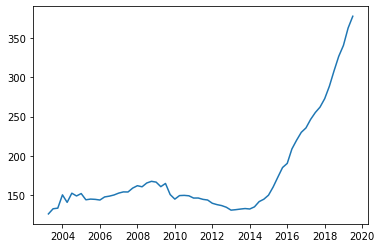

In [4]:
# Download the data on rents per sq.m. from ingatlannet.hu
dls = "https://www.mnb.hu/letoltes/mnb-lakasarindex.xlsx"
resp = requests.get(dls)
with open('mnb_houseprice.xls', 'wb') as output:
    output.write(resp.content)

# Use back-up file if the source no longer exists
if resp.status_code == 404:
    from shutil import copy
    copy("backup/mnb_house_price_index.xls","mnb_houseprice.xls")
    print("data missing from mnb.hu - using backup")
    
data_price = pd.read_excel('mnb_houseprice.xls', sheet_name = 1, header=0, 
                     names=['quarter', 'price'], usecols = [1, 3], skiprows = 3)
s = list(data_price['quarter']).index('2003. I.')
n = list([str(e) for e in list(data_price['quarter'])]).index('nan')
p = list(data_price['price'][s:n])

print('\nNominal price index (2001q1 = 100) extracted from mnb.hu:')
fig2, ax2 = plt.subplots()
ax2.plot(date[0:len(p)],p)
plt.show()

Finally, we combine the data from the two sources.

In [5]:
# Combine the data on rents and prices from the two sources:
r_apt = []
p_apt = []
ref = (int(t[0:4])-2003)*4 + math.floor(int(t[5:7])/3 - 1)
for i in range(0,len(p)):
    r_apt.extend([r[i]/r[ref] * rent_t])
    p_apt.extend([p[i] / p[ref] * price_t])

y = y[0:len(p)]
q = q[0:len(p)]
date = date[0:len(p)]

combined = pd.DataFrame({'Year':y, 'Quarter':q, 'Price':p_apt, 'M. Rent':r_apt})

print('\nCombined data for a '+str(sqm)+'-sq.m. average apartment in Budapest:\n')
print(combined.head(5))
print('...')


Combined data for a 50-sq.m. average apartment in Budapest:

   Year  Quarter      Price  M. Rent
0  2003        1  13,014.09    69.77
1  2003        2  13,685.68    67.63
2  2003        3  13,767.36    56.92
3  2003        4  15,500.81    55.36
4  2004        1  14,522.97    58.03
...


### Residential Investment - Structure of the Project
The next thing to think about is the structure of the residential investment project that we are going to consider. We make the following assumptions:
* We assume a five-year project. That is, the apartment is purchased, rented out, and then sold after five years. This is a rather short project, considering how illiquid the real-estate market is and how few transactions an average person makes in this market during their lifetime. However, this horizon is definitely feasible. Moreover, one could think, for example, about a 10-year investment as a combination of two back-to-back investment projects. The benefit of considering five years is that that this way, we make housing investment comparable with investment into 5-year government bonds, which are very popular today. Also, 5-year horizon implies that there are no capital-gain taxes in case of both housing and bond investment.
* We assume that the owner signs a one-year rental contract with the tenant with a fixed rental rate, and then the rental rate is increased after every year in order to catch up with the market rate. This is in line with the common practice that the rental rate is re-negotiated once a year.

In [6]:
# Reformat the data to record the buyinig, the selling prices, 
# and the rents for the last 5 years
data = pd.DataFrame({'Y':y[20:],'Q':q[20:],'Sell':p_apt[20:],
                     'Rent Y5':r_apt[16:-4],'Rent Y4':r_apt[12:-8],'Rent Y3':r_apt[8:-12],
                     'Rent Y2':r_apt[4:-16],'Rent Y1':r_apt[0:-20],'Buy':[-x for x in p_apt[0:-20]]})


print('\nThe data on cash flows for the five-year project:\n')
print(data.head(5))
print('...')


The data on cash flows for the five-year project:

      Y  Q       Sell  Rent Y5  Rent Y4  Rent Y3  Rent Y2  Rent Y1        Buy
0  2008  1  16,554.98    60.86    62.75    62.75    58.03    69.77 -13,014.09
1  2008  2  17,048.67    63.12    63.45    62.91    60.16    67.63 -13,685.68
2  2008  3  17,266.57    65.62    63.82    62.26    61.48    56.92 -13,767.36
3  2008  4  17,164.81    66.24    62.38    61.72    62.01    55.36 -15,500.81
4  2009  1  16,570.25    70.42    60.86    62.75    62.75    58.03 -14,522.97
...


### Assumptions about the costs
On top of this structure of the cash flows, we impose additional costs that we think represent the market for real estate:
* We assume that the stamp duty equal to 4% has to be paid upon the purchase. The underlying assumption is that the apartment is bought on the market to be rented out to a third party, and that there were no additional property trades within one year before and after the purchase (which would complicated the analysis tremendously). The duty is usually paid with a significant delay, and in case of a first purchase, it can be paid in 12 installments over 12 months. We assume that the duty is paid 6 months after the purchase.
* We assume that the investor must hire a lawyer to buy and sell the apartment. The costs of a lawyer are assumed to be 1% of the house price, which is within the range of 0.5-1.5% that one can typically find on the market.
* It is true that the investor can buy and sell the real estate without the realtor, by means of an online aggregator. To represent an average case, we assume that the investor uses the realtor to sell the apartment, but set the cost rather low, equal to 1% of the price of the apartment.
* The rental income is taxed. We assume that the investor files itemized deductions, so instead of paying 15% on 90% of total rental income, including payments for utilities, we assume that the investor pays 15% on the rent without utilities and net of depreciation. In addition, according to the Hungarian Tax Code, an additional 14% tax is imposed on any rental income exceeding 1 million forints within a calendar year. Also, the general guidelines by the Tax Authority suggest that the taxes should be paid simultaneously with the incoming payments, so we deduct the taxes from the rent in each month, and we deduct the extra 14% tax starting from the month when the total rental income exceeds 1 million forints.
* We assume that the flat depreciates at 2% per year. This rate is in line with existing international evidence on the depreciation rates for residential property, and it is in line with the Tax Code: for example, the deductible depreciation costs for long-term buildings owned by corporations is set at 2% per year.

In [7]:
# Assumptions
deprate = 0.02       # NAV 2%
purchase_tax = 0.04  # only paid if the first time purchase, ~6 months after the purchase
realtor_cost = 0.01  # only paid by the seller
legal_costs  = 0.01  # lawyer + land registry and transfer of utilities - both sales and purchases

Taking all these costs into account, we can finally get a more realistic set of cash flows for 61 months from the purchase to the sale of the apartment and compute the internal rate of return on residential property in Budapest:


Nominal realized IRR on 5-year investment into housing:


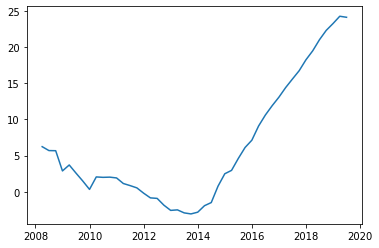

In [8]:
rates = []

for q in range(0,len(data['Y'])):
    # Compute the monthly cash flows
    # Compute the rental checks
    rent = []
    renty = []
    for y in range(1,6):
        rent.extend(list(np.tile(data['Rent Y'+str(y)][q],12)))
        renty.extend(list(np.tile(data['Y'][q]-6+y,data['Q'][q]*3)))
        renty.extend(list(np.tile(data['Y'][q]-5+y,(4-data['Q'][q])*3)))
    
    # Compute the taxes imposed on rental income
    in_tx = []
    hc_tx = []
    ys = list(range(min(renty),max(renty)+1))
    for y in ys:
        indices = [i for i, x in enumerate(renty) if x == y]
        rent_y = rent[min(indices):max(indices)+1]
        in_tx.extend([i * 0.15 for i in rent_y])
        y_tot = 0
        for x in rent_y:
            y_tot = y_tot + x
            if y_tot <= 1000:
                hc_tx.extend([0])
            else:
                hc_tx.extend([min(x*.14, (y_tot-1000)*.14)])
    
    # Compute the depreciation per month
    dep = []
    for price in p_apt[q:q+20]:
        dep.extend(list(np.tile(price * deprate / 12 * 0.85, 3)))
    
    # Assemble the cash flows together
    cf_all = [data['Buy'][q]*(1+legal_costs)]
    for i, x in enumerate(rent):
        cf_all.extend([rent[i]-in_tx[i]-hc_tx[i]-dep[i]])
    cf_all[6] = cf_all[6] + data['Buy'][q]*purchase_tax
    cf_all[-1] = cf_all[-1] + data['Sell'][q]*(1-realtor_cost-legal_costs)
    
    # Compute annualized IRR from monthly cash flows
    r_q = ((1+np.irr(cf_all))**12 - 1)*100
    
    # Record the results
    rates.extend([r_q])

# Plot the series
print('\nNominal realized IRR on 5-year investment into housing:')
plt.plot(date[20:],rates)
plt.show()

In [9]:
# Write the output in an xls file

#data = pd.DataFrame({'Date':date[20:],'Rate':rates})
#data.to_excel('results/returns_all.xls', sheet_name = 'housing', index=False)

os.remove('ingatlannet.xls')
os.remove('mnb_houseprice.xls')